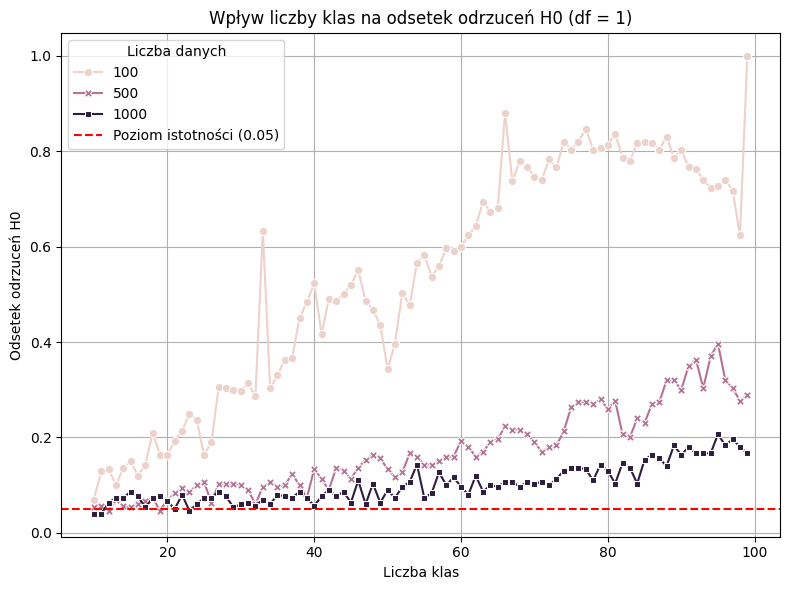

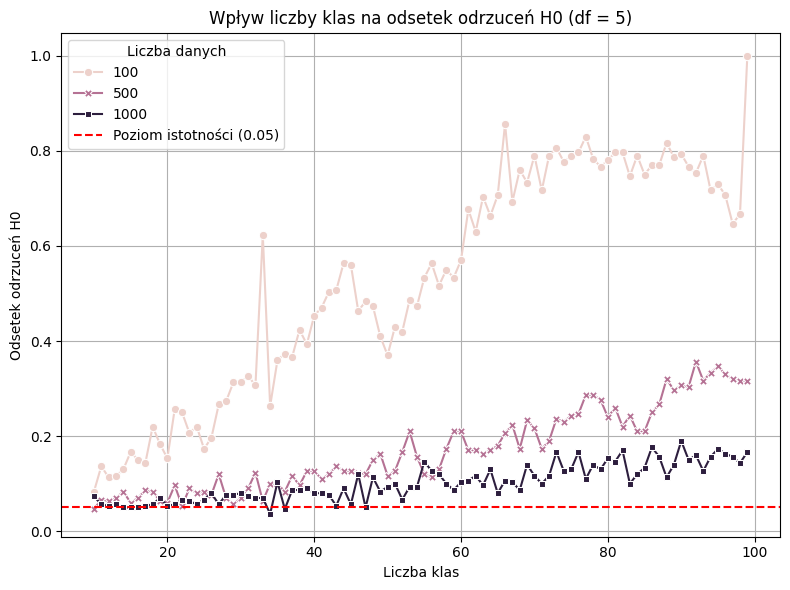

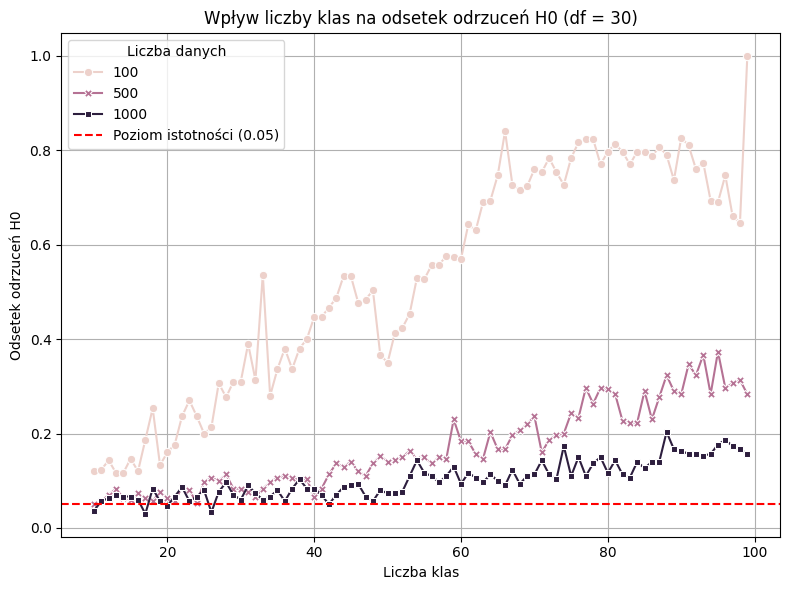

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Parametry
sample_sizes = [100, 500, 1000]
df_list = [1, 5, 30]
num_bins_detailed = list(range(10, 100)) 
alpha = 0.05
simulations_final = 300

# Funkcja testu chi2 względem rozkładu t
def chi2_test_t_distribution(data, df, num_bins):
    bin_edges = np.quantile(data, np.linspace(0, 1, num_bins + 1))
    observed_freq, _ = np.histogram(data, bins=bin_edges)
    cdf_vals = stats.t.cdf(bin_edges, df=df)
    expected_probs = np.diff(cdf_vals)
    expected_freq = expected_probs * len(data)
    mask = expected_freq > 0
    chi2_stat = ((observed_freq[mask] - expected_freq[mask]) ** 2 / expected_freq[mask]).sum()
    dof = np.count_nonzero(mask) - 1
    p_value = 1 - stats.chi2.cdf(chi2_stat, df=dof)
    return p_value

# Symulacja
results = []

for n in sample_sizes:
    for df_val in df_list:
        for num_bins in num_bins_detailed:
            rejections = 0
            for _ in range(simulations_final):
                data = stats.t.rvs(df_val, size=n)
                p_val = chi2_test_t_distribution(data, df_val, num_bins)
                if p_val < alpha:
                    rejections += 1
            rejection_rate = rejections / simulations_final
            results.append({
                'Sample Size': n,
                'Degrees of Freedom': df_val,
                'Number of Bins': num_bins,
                'Rejection Rate': rejection_rate
            })

# Konwersja do DataFrame
df_results = pd.DataFrame(results)

# Tworzenie wykresów
for df_val in df_list:
    plt.figure(figsize=(8, 6))
    subset = df_results[df_results['Degrees of Freedom'] == df_val]
    sns.lineplot(
        data=subset,
        x='Number of Bins',
        y='Rejection Rate',
        hue='Sample Size',
        style='Sample Size',
        markers=True,
        dashes=False
    )
    plt.axhline(alpha, color='red', linestyle='--', label='Poziom istotności (0.05)')
    plt.title(f'Wpływ liczby klas na odsetek odrzuceń H0 (df = {df_val})')
    plt.xlabel('Liczba klas')
    plt.ylabel('Odsetek odrzuceń H0')
    plt.grid(True)
    plt.legend(title='Liczba danych')
    plt.tight_layout()
    plt.show()

# Wnioski
# 1. Liczba klas ma istotny wpływ na odsetek odrzuceń prawdziwej hipotezy H0.
#    Im więcej klas, tym większe prawdopodobieństwo, że test chi2 odrzuci H0,
#    nawet jeśli dane pochodzą z rozkładu zgodnego z założeniami (t-Studenta).
# 2. Zjawisko to jest widoczne szczególnie przy:
#    - dużej liczbie klas (>40),
#    - małych próbkach (n = 100),
#    - oraz rozkładach o ciężkich ogonach (df = 1).
# 3. Dla df = 1 (ciężkie ogony), test jest bardzo czuły na liczbę klas –
#    przy n = 100 i liczbie klas 80–100 odsetek odrzuceń przekracza 80%.
# 4. Dla df = 5 i df = 30 trend jest podobny, ale efekt jest mniej nasilony:
#    - dla większych próbek (n = 1000) test nadal jest względnie stabilny,
#      ale liczba odrzuceń i tak rośnie przy większej liczbie klas.
# 5. W praktyce oznacza to, że należy uważać z arbitralnym zwiększaniem liczby klas w teście chi2.
#    Zbyt drobny podział może prowadzić do fałszywego odrzucenia poprawnej hipotezy.



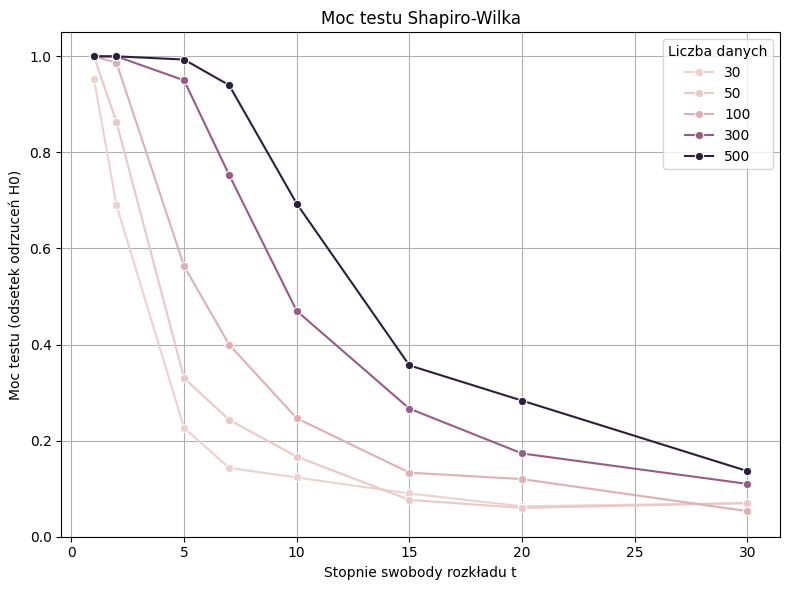

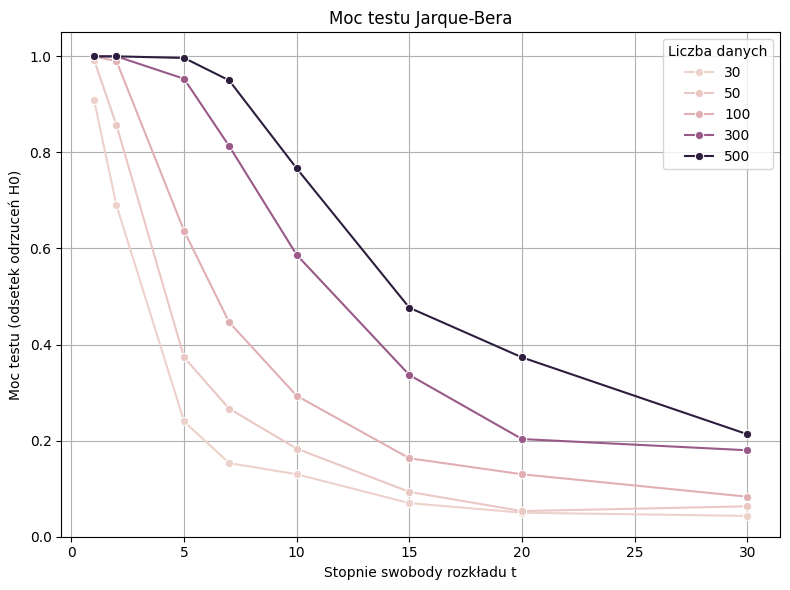

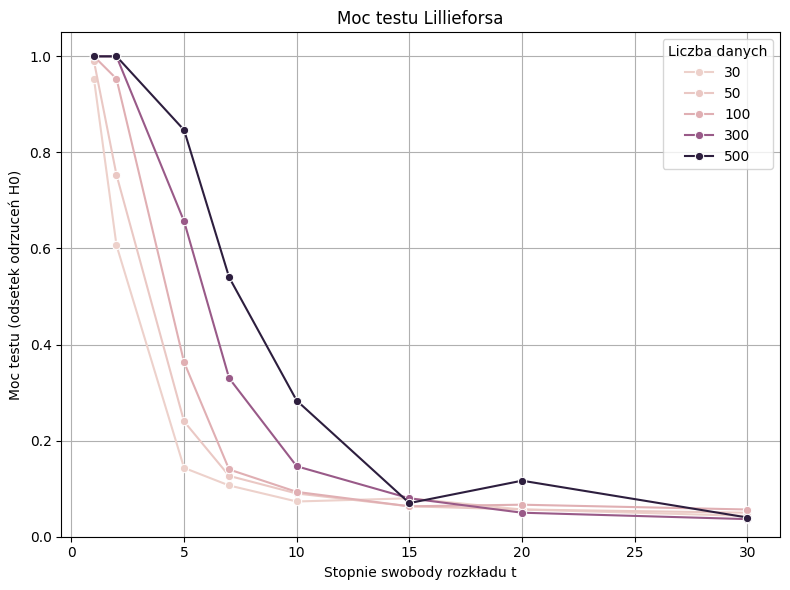

In [ ]:
from statsmodels.stats.diagnostic import lilliefors
from statsmodels.stats.stattools import jarque_bera
from scipy.stats import shapiro

# Parametry symulacji
sample_sizes = [30, 50, 100, 300, 500]
df_list = [1, 2, 5, 7, 10, 15, 20, 30]
n_simulations = 300
alpha = 0.05

# Wyniki
results = []

# Funkcja do testu Jarque-Bera
def jarque_bera_test(data):
    stat, p_value, _, _ = jarque_bera(data)
    return p_value

# Symulacja
for n in sample_sizes:
    for df_val in df_list:
        rejections_sw = 0
        rejections_jb = 0
        rejections_lf = 0

        for _ in range(n_simulations):
            data = stats.t.rvs(df_val, size=n)

            # Shapiro-Wilk
            try:
                if shapiro(data).pvalue < alpha:
                    rejections_sw += 1
            except:
                pass  

            # Jarque-Bera
            if jarque_bera_test(data) < alpha:
                rejections_jb += 1

            # Lilliefors
            _, p_lf = lilliefors(data)
            if p_lf < alpha:
                rejections_lf += 1

        results.append({
            'Sample Size': n,
            'Degrees of Freedom': df_val,
            'Shapiro-Wilk': rejections_sw / n_simulations,
            'Jarque-Bera': rejections_jb / n_simulations,
            'Lilliefors': rejections_lf / n_simulations
        })

# Tworzymy DataFrame
df_power = pd.DataFrame(results)

# Lista testów
tests = ['Shapiro-Wilk', 'Jarque-Bera', 'Lilliefors']
titles = {
    'Shapiro-Wilk': 'Moc testu Shapiro-Wilka',
    'Jarque-Bera': 'Moc testu Jarque-Bera',
    'Lilliefors': 'Moc testu Lillieforsa'
}

# Generowanie wykresów
for test in tests:
    plt.figure(figsize=(8, 6))
    sns.lineplot(
        data=df_power,
        x='Degrees of Freedom',
        y=test,
        hue='Sample Size',
        marker='o'
    )
    plt.title(titles[test])
    plt.xlabel('Stopnie swobody rozkładu t')
    plt.ylabel('Moc testu (odsetek odrzuceń H0)')
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.legend(title='Liczba danych')
    plt.tight_layout()
    plt.show()

# Wnioski
# 1. Shapiro-Wilk:
#    - Największa moc w porównaniu do pozostałych testów.
#    - Bardzo czuły nawet przy małych próbkach.
#    - Wykrywa odstępstwa od normalności nawet dla df = 10.
#
# 2. Jarque-Bera:
#    - Działa skutecznie głównie przy dużych próbkach (n > 100).
#    - Mniej czuły przy n < 100 — szczególnie dla umiarkowanych df.
#    - Lepiej wykrywa odstępstwa wynikające z skośności i kurtozy.
#
# 3. Lilliefors:
#    - Najbardziej konserwatywny — ma najniższą moc spośród testów.
#    - Jego skuteczność ograniczona głównie do bardzo niskich df (df = 1–2).
#    - Praktycznie niewrażliwy na umiarkowane odstępstwa przy większych df.
#
# Ogólna interpretacja:
# - Im mniejsze df, tym bardziej dane odbiegają od normalności, co skutkuje wyższą mocą testów.
# - Wszystkie testy tracą moc, gdy df > 10–15, ponieważ rozkład t zaczyna przypominać normalny.
# - Wybór testu zależy od liczebności próby: Shapiro-Wilk sprawdza się w każdych warunkach,
#   Jarque-Bera – przy większych próbach, Lilliefors – raczej pomocniczo.


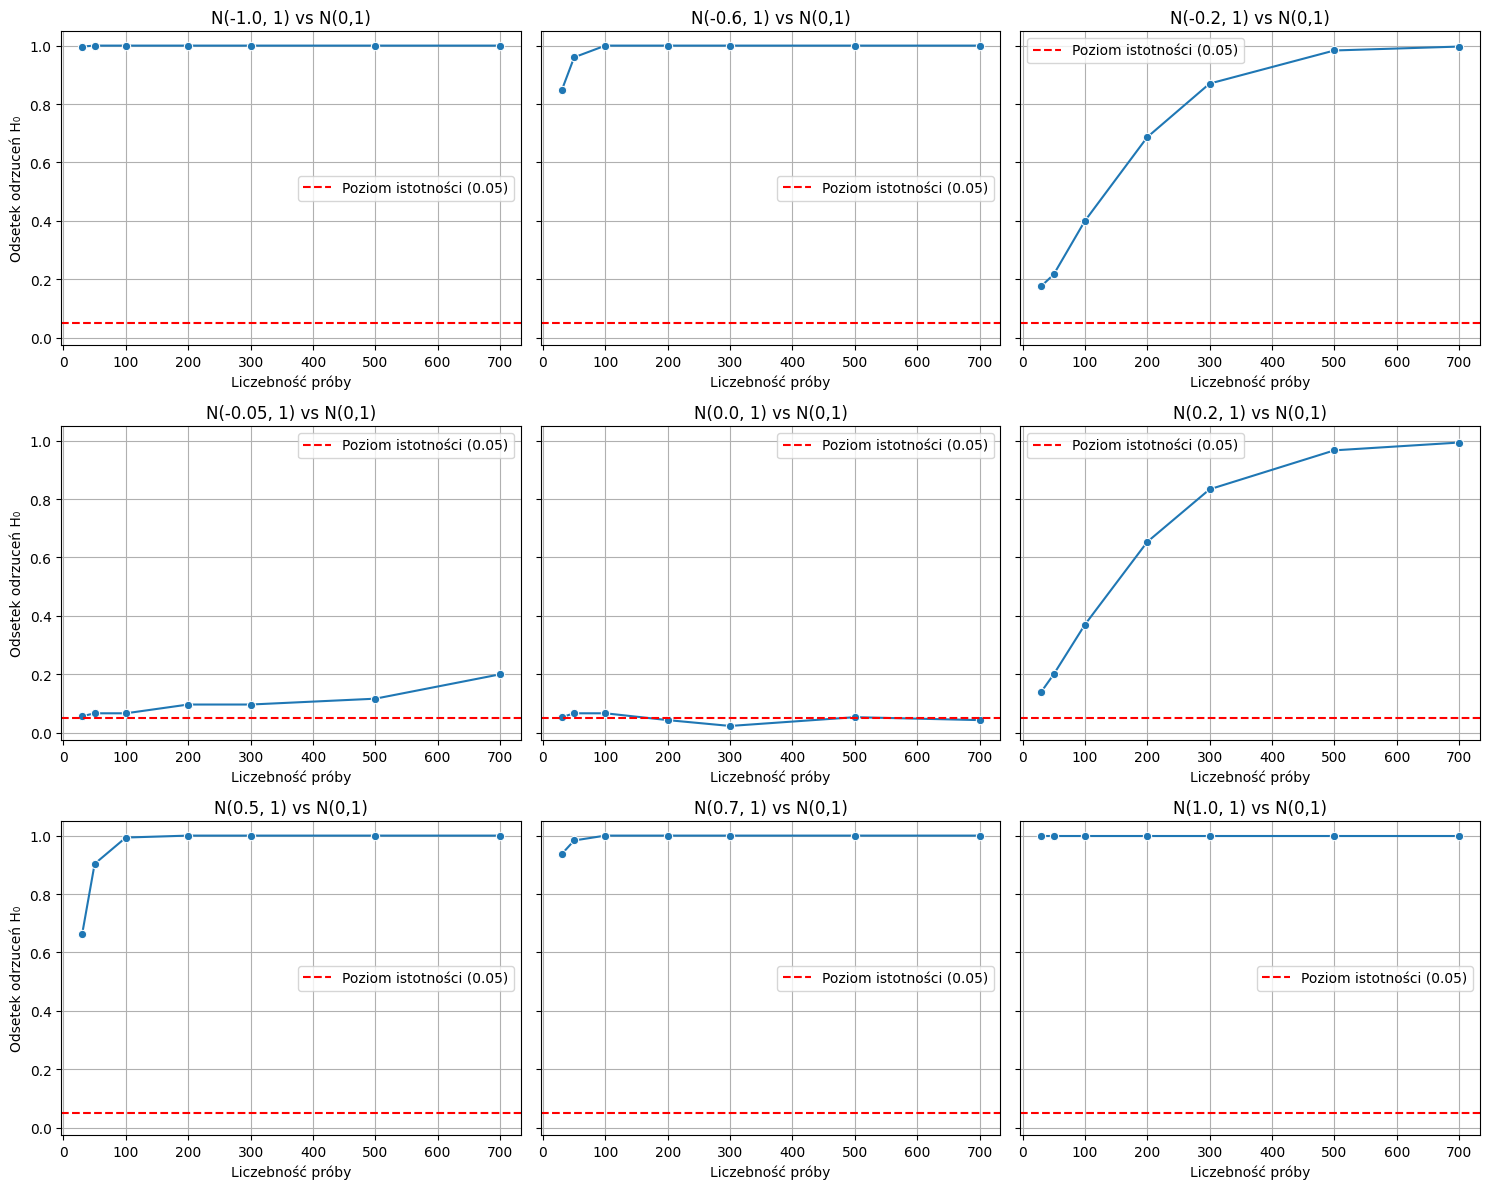

In [ ]:
# Parametry
means_to_test = [-1.0, -0.6, -0.2, -0.05, 0.0, 0.2, 0.5, 0.7, 1.0]
std_fixed = 1
sample_sizes_grouped = [30, 50, 100, 200, 300, 500, 700]
simulations_ks_expanded = 300
alpha = 0.05

# Wyniki
expanded_results = []

# Symulacja
for mu in means_to_test:
    for n in sample_sizes_grouped:
        rejections = 0
        for _ in range(simulations_ks_expanded):
            sample = np.random.normal(loc=mu, scale=std_fixed, size=n)
            d_stat, p_val = stats.kstest(sample, 'norm', args=(0, 1))  # Porównanie z N(0,1)
            if p_val < alpha:
                rejections += 1
        expanded_results.append({
            'Mean': mu,
            'Sample Size': n,
            'Rejection Rate': rejections / simulations_ks_expanded
        })

# Tworzenie DataFrame
df_ks_expanded = pd.DataFrame(expanded_results)

cols = 3
rows = int(np.ceil(len(means_to_test) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), sharey=True)

for idx, mu in enumerate(means_to_test):
    row = idx // cols
    col = idx % cols
    ax = axes[row, col] if rows > 1 else axes[col]
    
    subset = df_ks_expanded[df_ks_expanded['Mean'] == mu]
    sns.lineplot(data=subset, x='Sample Size', y='Rejection Rate', marker='o', ax=ax)
    ax.axhline(alpha, color='red', linestyle='--', label='Poziom istotności (0.05)')
    ax.set_title(f'N({mu}, 1) vs N(0,1)')
    ax.set_xlabel('Liczebność próby')
    ax.set_ylabel('Odsetek odrzuceń H0')
    ax.grid(True)
    ax.legend()

total_plots = len(means_to_test)
for i in range(total_plots, rows * cols):
    row = i // cols
    col = i % cols
    fig.delaxes(axes[row, col] if rows > 1 else axes[col])

plt.tight_layout()
plt.show()

# Wnioski
# 1. Dla m = 0.0 test zachowuje się poprawnie – odsetek odrzuceń około 0.05, co odpowiada poziomowi istotności.
#
# 2. Dla niewielkich przesunięć (+-0.05, +-0.2):
#    - Test KS wykazuje niską moc, szczególnie przy małych próbach (n < 100).
#    - Znaczna poprawa wykrywalności następuje dopiero przy n > 300.
#
# 3. Dla umiarkowanych przesunięć (+-0.5, +-0.7):
#    - Moc testu szybko rośnie z liczebnością próby.
#    - Już przy n = 100 test odrzuca H0 w ponad połowie przypadków.
#    - Przy n > 300 moc testu zbliża się do 1.
#
# 4. Dla dużego przesunięcia (+-1.0):
#    - Test KS niemal zawsze odrzuca H0 niezależnie od liczebności.
#    - Świetnie wykrywa różnice nawet przy n = 30.
#
# 5. Wzrost liczebności próby bardzo wyraźnie zwiększa moc testu – wykrywane są nawet subtelne różnice między rozkładami.
#
# Ogólne wnioski:
# Test Kołmogorowa-Smirnowa jest bardzo czuły na zmiany wartości oczekiwanej.
# Jednak przy bardzo małych przesunięciach i małych próbach może mieć ograniczoną moc.


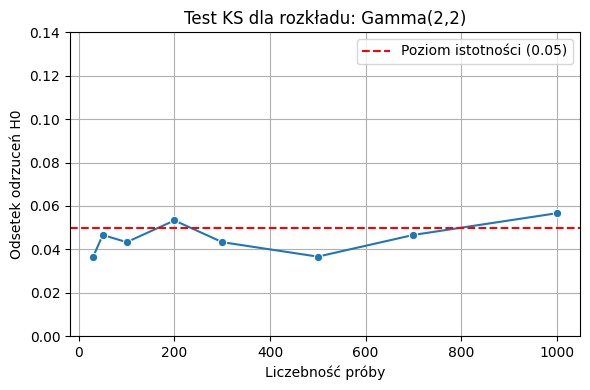

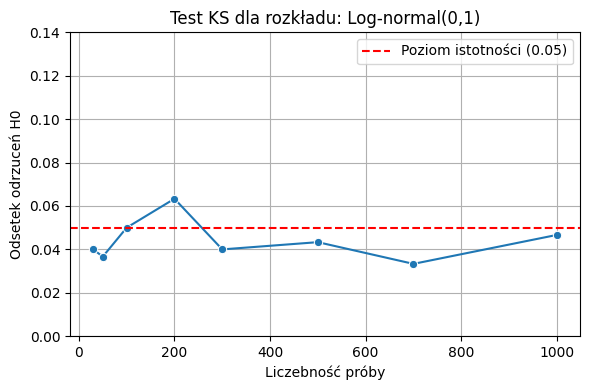

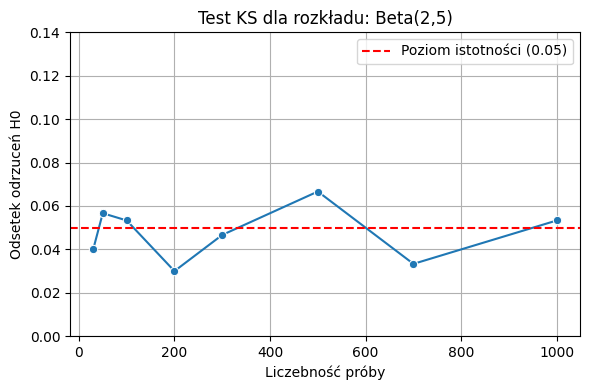

In [ ]:
# Parametry
sample_sizes_asym2 = [30, 50, 100, 200, 300, 500, 700, 1000]
simulations_asym2 = 300
alpha = 0.05

asym2_results = []

# 1. Gamma(2,2)
for n in sample_sizes_asym2:
    rejections = 0
    for _ in range(simulations_asym2):
        data = np.random.gamma(shape=2, scale=2, size=n)
        d_stat, p_val = stats.kstest(data, 'gamma', args=(2, 0, 2))  # shape, loc, scale
        if p_val < alpha:
            rejections += 1
    asym2_results.append({
        'Distribution': 'Gamma(2,2)',
        'Sample Size': n,
        'Rejection Rate': rejections / simulations_asym2
    })

# 2. Log-normal(0,1)
for n in sample_sizes_asym2:
    rejections = 0
    for _ in range(simulations_asym2):
        data = np.random.lognormal(mean=0, sigma=1, size=n)
        d_stat, p_val = stats.kstest(data, 'lognorm', args=(1, 0, np.exp(0)))  # sigma, loc, scale
        if p_val < alpha:
            rejections += 1
    asym2_results.append({
        'Distribution': 'Log-normal(0,1)',
        'Sample Size': n,
        'Rejection Rate': rejections / simulations_asym2
    })

# 3. Beta(2,5)
for n in sample_sizes_asym2:
    rejections = 0
    for _ in range(simulations_asym2):
        data = np.random.beta(a=2, b=5, size=n)
        d_stat, p_val = stats.kstest(data, 'beta', args=(2, 5, 0, 1))  # a, b, loc, scale
        if p_val < alpha:
            rejections += 1
    asym2_results.append({
        'Distribution': 'Beta(2,5)',
        'Sample Size': n,
        'Rejection Rate': rejections / simulations_asym2
    })

# Konwersja wyników do DataFrame
df_asym2 = pd.DataFrame(asym2_results)

# Wykresy 
distributions2 = df_asym2['Distribution'].unique()

for dist in distributions2:
    plt.figure(figsize=(6, 4))
    subset = df_asym2[df_asym2['Distribution'] == dist]
    sns.lineplot(data=subset, x='Sample Size', y='Rejection Rate', marker='o')
    plt.axhline(alpha, color='red', linestyle='--', label='Poziom istotności (0.05)')

    plt.ylim(0.00, 0.14)

    plt.title(f'Test KS dla rozkładu: {dist}')
    plt.xlabel('Liczebność próby')
    plt.ylabel('Odsetek odrzuceń H0')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Wnioski
# Gamma(2,2):
# Odsetek odrzuceń H0 oscyluje blisko poziomu istotności (0.05) dla każdej liczebności.
# Test nie wykazuje tendencji do nadmiernych odrzuceń mimo asymetrii.

# Log-normal(0,1):
# Mimo silnej prawostronnej asymetrii, test KS nie odrzuca H0 zbyt często.
# Odsetek odrzuceń pozostaje stabilny, bliski 0.05 dla wszystkich n.

# Beta(2,5):
# Test również zachowuje się prawidłowo.
# Widać większe fluktuacje przy małych próbach, ale nadal w granicach akceptowalnych.

# Posdumowanie:
# Test Kołmogorowa-Smirnowa nie odrzuca zbyt często prawdziwej hipotezy, nawet dla rozkładów o wyraźnej asymetrii. 
# Jego kalibracja jest poprawna, o ile rozkład teoretyczny w teście jest zgodny z rzeczywistym źródłem danych.